In [126]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import scipy.stats

In [ ]:
# Least-squares adjustment with a handful of Gaussian terms
# in the likelihood:  a numerical example

In [ ]:
# Randolf Pohl et al.  Deuteron charge radius and Rydberg constant from spectroscopy data in atomic deuterium
# https://arxiv.org/abs/1607.03165v1

# This paper gives a handful of (different) measurements of the deuteron 
# charge radius, and discusses a "Least squares adjustment" 
# which in plain language is a weighted sum of the measurements 
# aiming for a more accurate composite estimate of the not-precisely-known
# physical parameter.

# Least squares adjustments of this sort implictly assume that the 
# uncertainties are accurately communicated in earlier publications and that
# the distribution of "errors" which disturb the measurments from their true
# values are normally distributed.

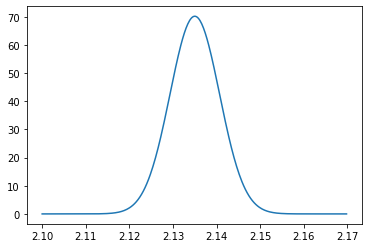

In [321]:
# Can I plot a Gaussian distribution? 
xscale = np.arange(2.10, 2.17, .0002)
g = scipy.stats.norm.pdf(xscale, scale=0.00568, loc=2.135)
plt.plot(xscale,g)

In [100]:
# Create arrays for the means and standard deviations of the estimates.  From table VII of Pohl. et a.

centers = np.array([2.1358, 2.1385, 2.1435, 2.1465, 2.1451, 2.121])
widths  = np.array([0.0064, 0.0081, 0.0064, 0.0059, 0.0068, .025])

In [323]:
# Create rectangular arrays for centers and widths to make scipy.stats.norm.pdf happy
centers_m = (centers[:,np.newaxis]* np.ones(len(xscale)))
widths_m  = (widths[:, np.newaxis]* np.ones(len(xscale)))
centers_m.shape, widths_m.shape, xscale.shape

((6, 350), (6, 350), (350,))

In [324]:
# generate 6 normal densities
g = scipy.stats.norm.pdf(xscale, loc=centers_m, scale=widths_m).T

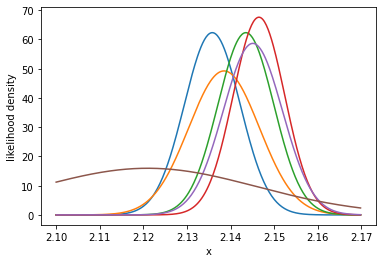

In [326]:
# plot the 6 normal densitites.  These are terms in my likelihood for the parameter of interest.
plt.plot(xscale,g)
plt.xlabel("x")
plt.ylabel("likelihood density")
plt.savefig("5normals.png", dpi=300, bbox_inches="tight")

In [39]:
g.shape

(70, 6)

In [327]:
# calculate final as the product of these six column's normal distributions
final = np.exp(np.sum(np.log(g), axis=1))

Text(0.5, 1.0, 'Posterior likelihood')

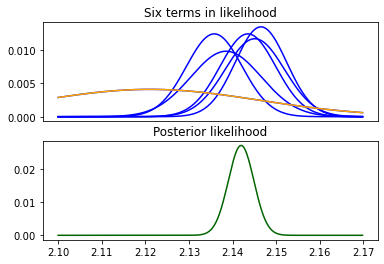

In [337]:
plt.subplot(211)
plt.plot(xscale,g/g.sum(axis=0), color="blue")
plt.plot(xscale, (g/g.sum(axis=0))[:,-1], color="orange")
plt.xticks([])
plt.title("Six terms in likelihood")
plt.subplot(212)
plt.plot(xscale, final/final.sum(axis=0), color="darkgreen")
plt.title("Posterior likelihood")


To find the mean and the variance (numerically) I need 
$$ E(x) = \int x P(x) dx $$ and 
$$ E(x^2) = \int x^2 P(x) dx $$ 
which I will approximate with `np.sum(P* x) / np.sum(P)` and `np.sum(P*x*x) / np.sum(P)` 

In [340]:
posterior = final/final.sum(axis=0)
expect_posterior = np.sum(xscale* posterior) 
expect_posterior

2.14195365674958

In [341]:
# variance? 

var_posterior = np.sum(xscale*xscale* posterior) - expect_posterior**2
std_posterior = np.sqrt(var_posterior)

# Guess first:  what are we expecting?  Standard deviation of mean of five 
# normal distributions... should be something like 0.0059 / sqrt(5) so .003

std_posterior

0.0029358052694424676

We could have found the mean and standard deviaton of the product of 
all six likelihoods by algebra, collecting terms of $x^2$ and $x$.

The width of the product of all the posterior distributions conspicuously 
does not depend on the means; this formalism assumes the standard deviations
are known (not estimated) and the difference of means information does not 
affect their (assumed) values.

The Bayesian product of normally-distributed uncertainties has the 
answer that is a weighted sum of the positions of the centers of the 
underlying measurements: 
$$ \mu_{total} = { \sum_i {\mu_i \over \sigma_i^2} \over {\sum_i { 1 \over \sigma_i^2} }}, 
  \sigma^2_{total} = \left( { \sum_i {1 \over \sigma_i^2 } } \right) ^{-1} $$ 



In [ ]:
#================================================


In [172]:
# Here I load in a much-loved dataset from 1888, Francis Galton's heights of 900
# adults and their parents.

galton = pd.read_csv("../data/galton.csv")
galton.head()
y = galton.childHeight.values

Text(0, 0.5, 'Number')

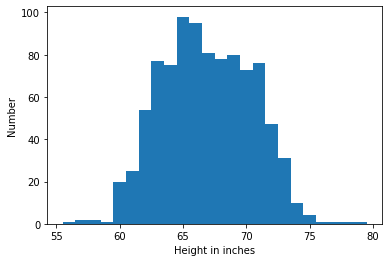

In [275]:
plt.hist(galton.childHeight, bins=np.arange(55, 80) + .5) 
plt.xlabel("Height in inches")
plt.ylabel("Number")

To make sure I can use optimization, let's try a test.

$$ LOSS_{SSE}(\theta; y)  = \sum (y-\theta)^2 $$

$$ \hat{\theta} = argmin_{\theta} \ \  LOSS_{SSE} (\theta; y) $$

If I wanted to replace all my y with a constant,
what number gives me the smallest summed error?



In [ ]:
# Here I define an extremely simple function.
# This function sums the squared-differences between
# each value in y and the paramter theta.
def LOSS_SSE( theta):
    assert len(theta) == 1
    return np.sum( (y - theta)**2 ) 

In [278]:
thetahat = minimize(SSE, 0)

In [195]:
def LOSS_NORMAL(parameter):
    return np.sum( -scipy.stats.norm.logpdf( y, loc=parameter[0], scale=parameter[1])  )  

In [166]:
LOSS_NORMAL([66.7,3.5])

2516.314916873552

In [167]:
LOSS_NORMAL([86.7,3.5])

17695.25369238376

In [165]:
minimize(LOSS_NORMAL, [66, 3.5], method="BFGS")

      fun: 2515.781800385769
 hess_inv: array([[0.07772882, 0.04119342],
       [0.04119342, 0.02304153]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([66.7459315 ,  3.57733453])

In [169]:
y.mean(), y.std()

(66.74593147751605, 3.5773346010057634)

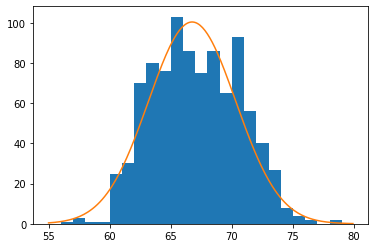

In [284]:
x = np.arange(55,80,.1)
yhat_g = scipy.stats.norm.pdf(x, loc=66.7459, scale=3.577)
plt.hist(y, bins=np.arange(55, 80))
plt.plot(x,yhat_g *900)

In [239]:
xgrid = np.arange(55,80,2) 
ygrid = np.arange(0.5, 20.0, 0.5)
xax, yax = np.meshgrid(xgrid, ygrid, indexing="ij")
z = np.zeros(xax.shape)
print(xax.shape, yax.shape, z.shape)
for i in range(len(xgrid)):
    for j in range(len(ygrid)):
        z[i,j]= LOSS_NORMAL((xgrid[i], ygrid[j]))


(13, 39) (13, 39) (13, 39)


In [240]:
range(len(xgrid))

range(0, 13)

In [ ]:
# Arright, I can't find how to plot the axes right without plt.contour and plt.contourf

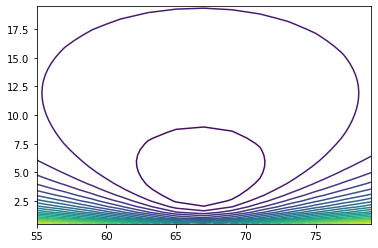

In [266]:
plt.contour(xax, yax, np.log(z), levels=30)
#plt.imshow(np.log(z))

In [252]:
def LOSS_NORMAL2(parameter2):
    return np.sum( -np.log(scipy.stats.norm.pdf( y, loc=parameter2[0], scale=parameter2[1]) 
                 + scipy.stats.norm.pdf( y, loc=parameter2[2], scale=parameter2[3]) ))  

In [254]:
LOSS_NORMAL2([60,3.5,70,3.5])
    

2189.586119511434

In [255]:
minimize(LOSS_NORMAL2, [63, 2, 70, 2], method="BFGS")

      fun: 1851.8674514407735
 hess_inv: array([[ 0.00783133,  0.01133038, -0.00259784,  0.0187608 ],
       [ 0.01133038,  0.02768016, -0.00456697,  0.0397389 ],
       [-0.00259784, -0.00456697,  0.00387407, -0.01253936],
       [ 0.0187608 ,  0.0397389 , -0.01253936,  0.07293249]])
      jac: array([ 0.00000000e+00, -1.52587891e-05,  1.52587891e-05,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 105
      nit: 15
     njev: 21
   status: 2
  success: False
        x: array([64.08472207,  2.2771205 , 69.42351661,  2.48216295])

In [262]:
xgrid2 = np.arange(55,80,2) 
ygrid2 = np.arange(55,80,2)
xax2, yax2 = np.meshgrid(xgrid2, ygrid2, indexing="ij")
z2 = np.zeros(xax2.shape)
print(xax2.shape, yax2.shape, z.shape)
for i in range(len(xgrid2)):
    for j in range(len(ygrid2)):
        z2[i,j]= LOSS_NORMAL2((xgrid2[i],2.27,  ygrid2[j], 2.48))


(13, 13) (13, 13) (13, 39)


array([[55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79]])

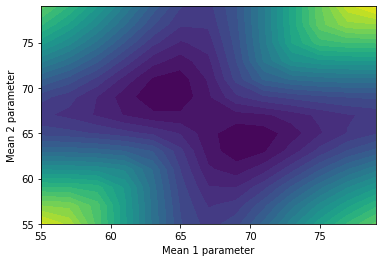

In [267]:
plt.contourf(xax2, yax2, np.log(z2), levels=30)
plt.xlabel("Mean 1 parameter")
plt.ylabel("Mean 2 parameter")
yax2

In [ ]:
# This is, believe it or not, reassuring.  There are two equal 
# optima, one with mean1 = 69 and mean2 = 64, and one with 
# mean1 = 64 and mean2 = 69; these correspond to switching the 
# labels between the large and the small groups.

Some questions for thought:  

The optimizer claimed victory after only 105 evaluations of the loss function.  How many times did I evaluate the loss function to make these contour maps?

The parameter space for my function was (mean1, std1, mean2, std2), that's four dimensions.
I plotted a two-dimensional slice, with std1 and std2 held fixed at their optmimum values.
Do you think std1 and std1 might be correlated with mean1 and mean2?

There were two paramters (sigma_1 and sigma_2) that were .. "similar."  What would happen to the fitting process if I set sigma_2 = sigma_1 ? 

There was one paramter that I failed to parameterize: the mixing coefficient.  In constructing the loss function I implicitly made the weights for normal 1 and normal 2 equal.    Would I get a better or worse fit if I let the algorithm fit the probability ratio between class 1 and class 2?



In [273]:
xgrid3 = np.arange(55,80,1) 
ygrid3 = np.arange(0.5,20,0.25)
xax3, yax3 = np.meshgrid(xgrid3, ygrid3, indexing="ij")
z3 = np.zeros(xax3.shape)
print(xax3.shape, yax3.shape, z.shape)
for i in range(len(xgrid3)):
    for j in range(len(ygrid3)):
        z3[i,j]= LOSS_NORMAL2((xgrid3[i],ygrid3[j] , 69.42351661 , 2.48))

(25, 78) (25, 78) (13, 39)


array([[55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79],
       [55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79]])

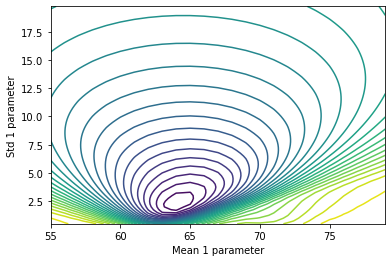

In [274]:
plt.contour(xax3, yax3, np.log(z3), levels=30)
plt.xlabel("Mean 1 parameter")
plt.ylabel("Std 1 parameter")
yax2

In [316]:
# In this part of the likelihood function, there is a bit of 
# correlation between mu1 and sigma1. 
# Correlations are typical...
# But these have the effect that optimization of one axis at a time
# can be difficult, because the best fit in one direction spoil
# the fit in other directions.

In [281]:
# The two-paramter fit results were
thetahat = [64.08472207,  2.2771205 , 69.42351661,  2.48216295]
# and that was for the function 
yhat = 0.5 * scipy.stats.norm.pdf(x, loc=thetahat[0], scale=thetahat[1]) + 0.5 * scipy.stats.norm.pdf(x, loc=thetahat[2], scale=thetahat[3])

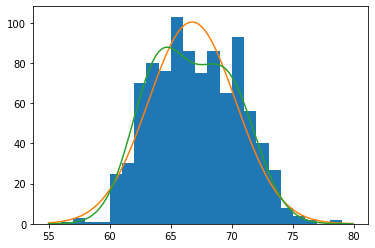

In [285]:
x = np.arange(55,80,.1)
yhat_g = scipy.stats.norm.pdf(x, loc=66.7459, scale=3.577)
plt.hist(y,  bins=np.arange(55, 80))
plt.plot(x,yhat_g *900)
plt.plot(x, yhat*900)

In [288]:
galton.head(1)

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2


In [289]:
# Create a column whose value is 1 if gender is male, 0 otherwise: 
galton["indicator"] =  galton.gender == "male"

indicator
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: childHeight, dtype: object

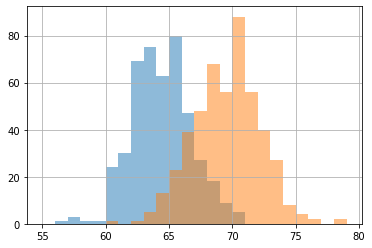

In [294]:
galton.groupby(by="indicator").childHeight.hist(alpha=0.5, bins=np.arange(55, 80))

In [295]:
# We can get the per-category mean and standard devation
galton.groupby(by="indicator").childHeight.describe()

,count,mean,std,min,25%,50%,75%,max
indicator,,,,,,,,
False,453.0,64.103974,2.355653,56.0,62.5,64.0,65.5,70.5
True,481.0,69.234096,2.623905,60.0,67.5,69.2,71.0,79.0


In [299]:
# And can write down theoretical densities
density1 = scipy.stats.norm.pdf(x, loc=64.103974, scale=2.355653)
density2 = scipy.stats.norm.pdf(x, loc=69.234096, scale=2.623905)

indicator
False    AxesSubplot(0.547727,0.125;0.352273x0.755)
True     AxesSubplot(0.547727,0.125;0.352273x0.755)
Name: childHeight, dtype: object

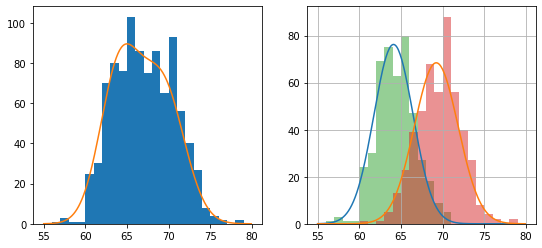

In [315]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.hist(y,  bins=np.arange(55, 80))
plt.plot(x, np.array([(density1+density2)*450 ]).T ) 
plt.subplot(122)
plt.plot(x, np.array([density1*450, density2*450 ]).T ) 
galton.groupby(by="indicator").childHeight.hist(alpha=0.5, bins=np.arange(55, 80))


In [304]:
x[np.min(np.where(density1<density2))]

66.70000000000016

In [308]:
galton["class"] = galton.childHeight > 67.7 
galton.groupby(["class", "indicator"]).indicator.count()

class  indicator
False  False        421
       True         129
True   False         32
       True         352
Name: indicator, dtype: int64

In [332]:
# I can pause for a moment and compute how well my one-dimensional
# classifier has done on the training data:
#  Correct: 773    Incorrect:  161 
#  Errors incorrectly classified as M : 32
#         incorrectly classified as F: 129 

len(galton), galton.indicator.sum(), galton.indicator.sum()/len(galton)

(934, 481, 0.5149892933618844)

In [334]:
# overall accuracy, adjusted for nothing:
773/934

0.8276231263383298

Bayes' rule for inferring probability of class $\mathcal{C}_k $  ($k$ is the index that counts $r$ classes) given data $x$: 
$$ P(\mathcal{C}_k | x) = {P(x| \mathcal{C}_k) P(\mathcal{C}_k) \over P(x)}  $$

And the probability that $x$ came from class  $\mathcal{C}_1 $ is

$$ P(\mathcal{C}_1 | x) = {P(x| \mathcal{C}_1) P(\mathcal{C}_1) \over 
\displaystyle\sum_{i=1}^r P(x| \mathcal{C}_i) P(\mathcal{C}_i) }  $$


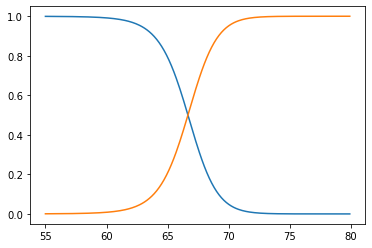

In [310]:
# If I want a graph of my model's posterior probability of being
# in class 1 or class 2 as a function of x: 

p_class1 = density1 /(density1 + density2)
p_class2 = density2 /(density1 + density2)

plt.plot(x,p_class1)
plt.plot(x,p_class2) 